# Problem set 2

## Team
Please write here your names and team number.

* Team name: Group F
* Team members:
    1. Aditi Joshi (243311)
    2. Dominik Allen (232487)
    3. Lonny Chen (216697)

### 📝 Solution Notes
1. 📝 Additional code explanations are provided where appropriate.
2. `#ADDED` indicates extra code needed during debug/development beyond the assigned "TODO" including additional libraries.
3. `#EDITED` indicates original code that was intentionally edited
4. ⚙️ Notebook execution supports both NVIDIA and Apple GPUs (both were used during development).

### 🔗 Table of Contents
1. [Task 1: Transform the data](#Task-1:-Transform-the-data-(10-pt))
2. [Task 2: Implement a max pooling class and a CNN model](#Task-2:-Implement-a-max-pooling-class-and-a-CNN-model(15-pt))
3. [Task 3: Tune your training hyperparameters](#Task-3:-Tune-your-training-hyperparameters-(optional,-10-pt))
4. [Task 4: Load and fine-tune a pre-trained model](#Task-4:-Load-and-fine-tune-a-pre-trained-model-(10-pt))
5. [Task 5: Results and discussion](#Task--5:-Results-and-discussion-(5pt))
6. [References](#References)

## Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

## Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Make sure that all your work has been pushed to GitHub before the deadline.


Check that the GPU  enabled in your colab notebook by running the cell below.

In [1]:
import torch

#ADDED device priority selection
if torch.cuda.is_available():
    device = 'cuda:0' #NVIDIA GPU
elif torch.backends.mps.is_available():
    device = 'mps' #Apple GPU
else:
    device = 'cpu'

# Check is GPU is enabled
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #EDITED
print("Device: {}".format(device))

# Get specific GPU model (CUDA only)
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: mps


You will be working with the EuroSAT dataset. The dataset contains 8489 pictures of 3 different land coverage types (crop, herbaceous vegetation and river). Running the lines below will download the data and return a random picture from the dataset.

The dataset has 27000 images
Picture number 12749 with label: 4


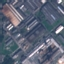

In [2]:
from torchvision.datasets import EuroSAT
import os
import numpy as np

data = EuroSAT(root=os.getcwd(), download=True) #downloads the dataset to your current directory
print(f"The dataset has {len(data)} images")
randint = np.random.randint(len(data))

pic, tar = data[randint]
print(f"Picture number {randint} with label: {tar}")
pic

In [3]:
#ADDED: additional dataset inspection
print(f'Dataset type {type(data)}')
print(f'Dataset element type {type(data[0])}')
print(f'Target type {type(data[0][1])}') #second element of tuple
print(f'Image type {type(data[0][0])}') #first element of tuple

Dataset type <class 'torchvision.datasets.eurosat.EuroSAT'>
Dataset element type <class 'tuple'>
Target type <class 'int'>
Image type <class 'PIL.Image.Image'>


In [4]:
#ADDED: additional PIL image inspection
print(f'Image mode: {data[0][0].mode}')
print(f'Image size: {data[0][0].size}')
print(f'Image numpy shape: {np.array(data[0][0]).shape}')

Image mode: RGB
Image size: (64, 64)
Image numpy shape: (64, 64, 3)


## Task 1: Transform the data (10 pt)

 Your task is to train a classifier to classify the different land usage types in the dataset. We want to select only the 50 most frequent people in the dataset, all the other people should be mapped to a common class.
- Implement the class `rotate` that maps pictures to flipped pictures by 90, 180, 270 or 360°. The class should return an error if you try to rotate the picture by other degrees.
- Plot a histogram with the frequencies of each class. Make sure to insert both name and label in the histogram (e.g. `AnnualCrop:0`).
- We create a class `RotateEuroSAT` that takes as input the original dataset and returns a new dataset which contains randomly rotated pictures and whose label proportion can be customized.
Implement the class method `_create_rotated_dataset` that returns this pictures using the previously implemented `rotate`.
- `RotateEuroSAT` should also take care of transforming the pictures to tensors and optionally move the tensor to a GPU device.

In [5]:
from torch.utils.data import Subset, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np

#ADDED: libraries
import seaborn as sns
sns.set_style("darkgrid")
import textwrap
from PIL import Image
from torchvision import transforms

### 📝 `rotate_picture`
The EuroSAT images are of type [PIL.Image.Image](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image) so we use their handy [rotate](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.rotate) function here.

In [6]:
def rotate_picture(picture, rotation):
    '''#DONE: implemented most frequent n people'''
    #Return AssertionError if other rotation input
    assert rotation in [90, 180, 270, 360], 'Rotation angle is not a multiple of 90°'

    #Use PIL.Image.Image.rotate
    return picture.rotate(rotation) #counter-clockwise

### 📝 `plot_histogram`
We make use of some available attributes from the `EuroSAT` class (from [DatasetFolder](https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.DatasetFolder.html#torchvision.datasets.DatasetFolder)) to assist with class frequency plotting. <br>
For plotting, we use **Seaborn** for code efficiency and native **Matplotlib** commands only when needed. <br>
This same function is reused to verify the class frequencies in our instance of `RotateEuroSAT`.

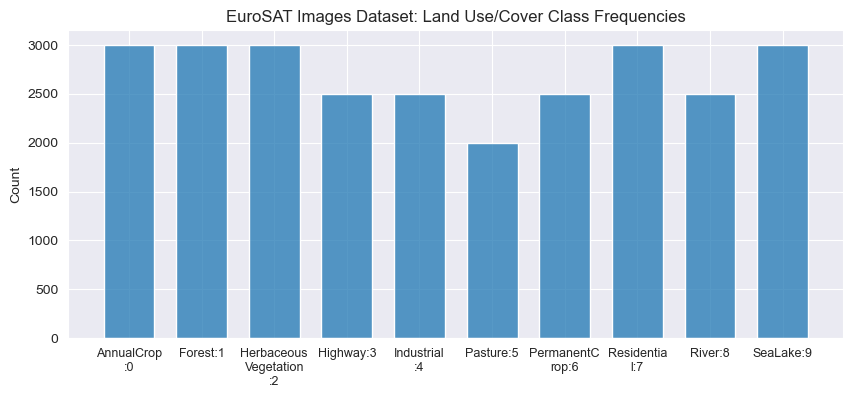

In [7]:
def plot_histogram(data):

    fig, ax = plt.subplots(figsize=(10, 4)) #EDITED from: (10, 6)
    '''#DONE: here your code'''
    xlabels = [f'{k}:{v}' for k, v in data.class_to_idx.items()]
    xlabels_wrapped = [textwrap.fill(xl, width=10) for xl in xlabels]
    sns.histplot(data=data.targets, bins=len(data.classes), discrete=True, shrink=0.7)
    plt.xticks(list(data.class_to_idx.values()), xlabels_wrapped, fontsize=9)

    return fig, ax

fig, ax = plot_histogram(data)
plt.title('EuroSAT Images Dataset: Land Use/Cover Class Frequencies'); #ADDED
#fig.show() #EDITED

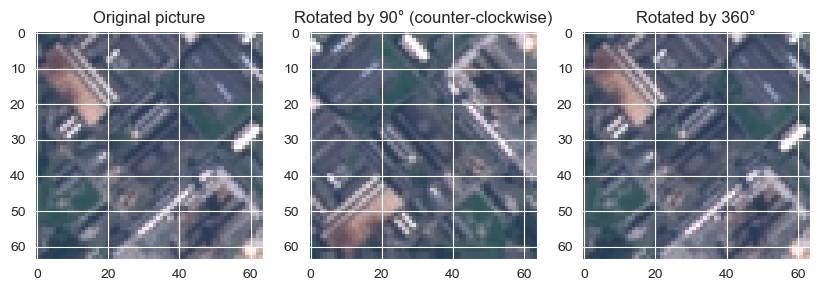

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

new_pic = rotate_picture(pic, 90) # Example of rotating a picture by 90 degrees
same_pic = rotate_picture(pic, 360) # Example of rotating a picture by 360 degrees (should return the same picture)

axes[0].imshow(pic)
axes[0].set_title("Original picture")
axes[1].imshow(new_pic)
axes[1].set_title("Rotated by 90° (counter-clockwise)")
axes[2].imshow(same_pic)
axes[2].set_title("Rotated by 360°");

### 📝 `RotateEuroSAT`
**Inside method `_create_rotated_dataset`:**<br>
Since a full dataset needed to be returned that can have an image/label tuple accessed by index in `__getitem__`, we decided to define a subclass of `Dataset` called `MyRotatedDataset`, instantiate it based on the original data and sampling parameters, and return the object.
- "transforming the pictures to tensors" (and labels!) are taken care of inside the `__getitem__` of `MyRotatedDataset`
-  "optionally move the tensor to a GPU device" is done through the `device` parameter upon data loading

In [9]:
class RotateEuroSAT(Dataset):
    def __init__(self,
                 original_data:Dataset,
                 length:int,
                 shares:list,
                 device=None,
                 seed=42):

        self.original_data = original_data
        self.length = length
        assert sum(shares) == 1, "Shares must sum to 1"
        assert len(shares) == len(original_data.classes), "Shares must match number of classes"
        self.shares = shares
        self.seed = seed
        self.device = device
        self.dataset = self._create_rotated_dataset()

        #ADDED for `plot_histogram` compatibility
        self.class_to_idx = original_data.class_to_idx
        self.classes = original_data.classes
        self.targets = [self.dataset[idx][1].item() for idx in range(self.length)]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        picture, label = self.dataset[idx]
        return picture, label

    def _create_rotated_dataset(self):
        """#DONE: implement solution"""

        class MyRotatedDataset(Dataset):
            def __init__(self, original_data, length, shares, seed, device):
                #Set random seed
                np.random.seed(seed)

                #Per-class loop to get random indices by class shares
                indices = []
                for target, share in enumerate(shares):
                    target_indices = (torch.tensor(original_data.targets) == target).nonzero(as_tuple=True)[0] #GPT Q&A
                    indices += np.random.choice(target_indices, size=int(length*share), replace=False).tolist() #w/o replacement

                #Create new dataset pre-rotation
                self.randomized_dataset = Subset(original_data, indices)
                self.to_tensor = transforms.ToTensor()
                self.device = device

            def __len__(self):
                return len(self.length)

            def __getitem__(self, idx):
                #Perform randomized rotation upon data loading
                rotation = np.random.choice([90, 180, 270, 360])
                image = rotate_picture(self.randomized_dataset[idx][0], rotation)
                label = self.randomized_dataset[idx][1]

                # +1. Needed to use data in PyTorch neural networks
                image_tensor = self.to_tensor(image)
                label_tensor = torch.tensor(label)

                # +2. Optionally move to GPU (upon loading)
                if self.device:
                    image_tensor = image_tensor.to(self.device)
                    label_tensor = label_tensor.to(self.device)

                return image_tensor, label_tensor

        # Instantiate and return rotated dataset
        dataset = MyRotatedDataset(self.original_data, self.length, self.shares, self.seed, self.device)

        return dataset


In [10]:
rotated_data = RotateEuroSAT(data,
                             length=10**4,
                             shares=[1 / len(data.classes) for _ in data.classes],
                             seed=42,
                             device=device) #ADDED to optionally put data on the specified device

train_data, test_data = random_split(rotated_data, [0.8, 0.2])

In [11]:
#ADDED: check data type and device
print(type(rotated_data[0][0])) #PIL is a Tensor now!
print(rotated_data[0][0].device) #on MPS!
print(rotated_data[0][0].shape) #[3, 64, 64]

<class 'torch.Tensor'>
mps:0
torch.Size([3, 64, 64])


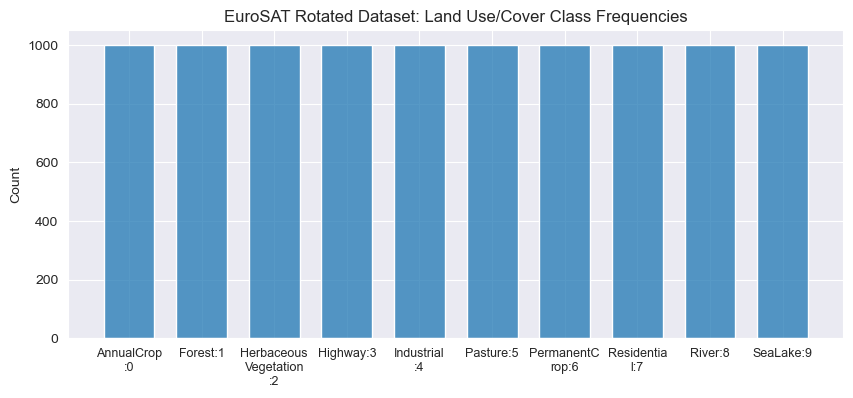

In [12]:
#ADDED: check histogram to verify class frequencies
fig, ax = plot_histogram(rotated_data)
plt.title('EuroSAT Rotated Dataset: Land Use/Cover Class Frequencies');

## Task 2: Implement a max pooling class and a CNN model(15 pt)
Implement a classification model to predict the label of the faces in the dataset. You are free to experiment with the network architecture. However your model **must** contain:
- At least one max pooling layer, implemented with `MyMaxPool`,
- Convolutional, linear, and pooling layers only,
- At least 3 convolutional layers, with at least two different kernel sizes,
- A final output layer that is customizable to the number of classes that we want to predict.

#### Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences).
We started with empirically successful architectures from the literature as baseline points while considering the task constraints being (a) the 64x64x3 dimensions of the EuroSAT images, (b) the network layers available to us, and (c) limited compute time and resources.<br><br>
The **DALNet-7** (Dominik-Aditi-Lonny) architecture is a **middle ground between AlexNet and VGG-11**, appropriate for our input and output dimensions, aiming to use the knowledge that "deeper" (more layers) and "narrower" (smaller kernel sizes) CNNs are generally more effective (Zhang et al., 2023), and that the "stacked" convolutional layers of VGG-11 capture more patterns by successively increasing the "receptive field".<br><br>
Some variations were tested, including final channel size (up to 512), number of stacked convolutions (up to 3), and number/size of fully-connected layers, and the final architecture (with admittedly small accuracy margins over simpler architectures) is sketched below.

![CNN diagram](https://github.com/hertie-data-science-lab/assignment-2-ps-2f/blob/master/CNN_diagram.jpg?raw=1)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F #ADDED for nn.functional.pad

### 📝 `MyMaxPoolSlow`
Our first attempt at `MyMaxPool` was derived from the "from scratch" convolutional layer provided in **Lab 4: Introduction to CNN**, simplified to just a `torch.max(region)` operation once the region within the input image was located (per-image-in-batch, per-channel). However, this proved to lack the "vectorization" needed to be usable inside our CNN.

In [14]:
#ADDED
class MyMaxPoolSlow(nn.Sequential):
    def __init__(self,
                 kernel_size,
                 stride=1,
                 padding=0):

        super().__init__()
        '''#DONE: construction your model'''

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        '''#DONE: forward step'''

        #Heavily "inspired" by Lab 4 "Constructing a convolutional layer"
        #Setup initial dimension variables
        if x.dim() < 4:
            x = x.unsqueeze(0) # shape becomes (1, C, H, W)
        batch_size, in_channels, H, W = x.shape
        if self.padding > 0:
            x = F.pad(x, (self.padding,) * 4) # padding (W, W, H, H)

        out_list = []
        for b in range(batch_size):
            x_b = x[b] #one sample in batch

            out_b_list = []
            for ch in range(in_channels):
                x_bc = x_b[ch] #one channel in sample

                #Calculate, setup output dimensions
                H, W = x_bc.shape
                out_H = (H - self.kernel_size)//self.stride + 1
                out_W = (W - self.kernel_size)//self.stride + 1
                out_bc = torch.zeros((out_H, out_W))

                #Per-channel: max pooling loop through H, W of x
                for i in range(out_H):
                    for j in range(out_W):
                        h_start = i * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = j * self.stride
                        w_end = w_start + self.kernel_size
                        region = x_bc[h_start:h_end, w_start:w_end]

                        #Actual max pooling operation!
                        out_bc[i, j] = torch.max(region)
                out_b_list.append(out_bc)

            out_b = torch.stack(out_b_list)
            out_list.append(out_b)

        out = torch.stack(out_list)
        return out.to(device)


### 📝 `MyMaxPool`
The preceding class definition was input into ChatGPT to ask for a truly "vectorized" (no Python looping) version. The code below was **generated by ChatGPT** and used in the `MyMaxPool` that is contained in our CNN.

`#Create sliding windows using unfold (vectorized)`<br>
`x_unf = x.unfold(2, k, s).unfold(3, k, s)  # shape: N x C x out_H x out_W x k x k`<br>
`out, _ = x_unf.contiguous().view(N, C, out_H, out_W, -1).max(dim=-1)`

In [15]:
class MyMaxPool(nn.Sequential):
    def __init__(self,
                 kernel_size,
                 stride=1,
                 padding=0):

        super().__init__()

        '''#DONE: construction your model'''
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):

        '''#DONE: forward step'''
        if x.dim() < 4:
            x = x.unsqueeze(0) # shape becomes (1, C, H, W)
        batch_size, in_channels, H, W = x.shape
        if self.padding > 0:
            x = F.pad(x, (self.padding,) * 4) # padding (W, W, H, H)

        #Calculate, setup output dimensions
        N, C, H, W = x.shape
        k = self.kernel_size
        s = self.stride
        out_H = (H - k) // s + 1
        out_W = (W - k) // s + 1

        #Create sliding windows using unfold (vectorized)
        x_unf = x.unfold(2, k, s).unfold(3, k, s)  # shape: N x C x out_H x out_W x k x k
        out, _ = x_unf.contiguous().view(N, C, out_H, out_W, -1).max(dim=-1)

        return out.to(device)

In [16]:
#ADDED: testing of `MyMaxPool*` compared to `nn.MaxPool2d` using an image from real training data
X, y = train_data[8]
#my_maxpool = MyMaxPoolSlow(2, 2)
my_maxpool = MyMaxPool(2, 2)
maxpool2d = nn.MaxPool2d(2, 2)
(my_maxpool(X) == maxpool2d(X)).all()

tensor(True, device='mps:0')

### 📝 `MyCNNModel`
The generic class example from **Lab 4: Introduction to CNN** was used as a reference to define our CNN model to be generic for a parametrized number of:
- Convolutional layers including stacking
- Fully-connected layers

This setup enabled the architecture "variations testing" mentioned above.

In [17]:
class MyCNNModel(nn.Sequential):

    def __init__(self,
                 conv_spec: list[list[tuple]],
                 fc_spec: list[tuple],
                 n_classes):

        '''#DONE: construction your model'''
        # 1. Build `layers` list of NN modules from `conv_spec` list of Conv2d spec tuples
        layers = []

        # 1a. Add "stacked" convolutional layers:
        for conv_i in conv_spec:
            for j, (ich, och, k, s, p) in enumerate(conv_i):
                layers.extend([
                    nn.Conv2d(in_channels=ich, out_channels=och, kernel_size=k, stride=s, padding=p),
                    nn.ReLU()
                ])
            #layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            layers.append(MyMaxPool(kernel_size=2, stride=2))

        # 1b. Add fully-connected layers
        layers.append(nn.Flatten())
        for i, (ifeat, ofeat) in enumerate(fc_spec):
            layers.append(nn.Linear(in_features=ifeat, out_features=ofeat))
            if i < (len(fc_spec)-1):
                layers.append(nn.ReLU())
        # Return "logits" here -> Y_pred -> nn.CrossEntropyLoss (softmax + NLLLoss)

        # 2. Call parent class constructor method with built-up `layers` list
        super().__init__(*layers)

    #def forward(self, x): #EDITED: forward did not need to be overridden
        '''#DONE: forward step'''

In [18]:
'''#DONE: print one iteration of your model to test its correctness'''

#ADDED
n_classes = len(data.classes)

#DALNet-7 spec
conv_spec = [[(3, 64, 5, 1, 2)], #Conv Layer 1 -> 64x64x64 -> 32x32x64
              [(64, 128, 3, 1, 1), (128, 128, 3, 1, 1)],  #Conv Layer 2 -> 32x32x128 -> 16x16x128
              [(128, 256, 3, 1, 1), (256, 256, 3, 1, 1)]] #Conv Layer 3 -> 16x16x256 -> 8x8x256
fc_spec = [(8*8*256, 1024), (1024, n_classes)] #FC1 -> Output

my_model = MyCNNModel(conv_spec, fc_spec, n_classes).to(device) #EDITED: need spec arguments
X, y = train_data[0]
my_model(X[None, :])

tensor([[-0.0177,  0.0003,  0.0034, -0.0165,  0.0235, -0.0083, -0.0124,  0.0174,
          0.0100,  0.0136]], device='mps:0', grad_fn=<LinearBackward0>)

## Training

We define a `Trainer` function to train our model that returns avg loss and avg accuracy per epoch. We set the configuration of the trainer is set in the `cfg` dictionary. Use the trainer to train your model and make sure to print and plot avg loss and accuracy using the in-built commands.

In [19]:
from datetime import datetime as dt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

cfg = {
    'batch_size': 64,
    'criterion': 'CrossEntropyLoss', #change to 'nn.NLLLoss' if you are applying a softmax in the last layer of your model
    'epochs': 10, #EDITED from: 1
    'learning_rate': 0.001,
    'optimizer':'Adam',
    'seed':42,
}

class Trainer:

    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg

        for key, val in cfg.items():
            setattr(self, key, val)

        self.optimizer = getattr(optim, self.optimizer)(self.model.parameters(), lr=self.learning_rate)
        self.criterion = getattr(nn, self.criterion)()


    def iter_step(self, X, Y):

        # ADDED: move batches to the same device as the model (needed for Task 4 ResNet)
        X = X.to(next(self.model.parameters()).device)
        Y = Y.to(next(self.model.parameters()).device)

        Y_pred = self.model(X)
        loss = self.criterion(Y_pred, Y)
        acc = (Y_pred.argmax(dim=-1) == Y).to(torch.float).mean()
        return loss, acc

    def train(self, dataset):
        train_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))
        avg_loss, avg_acc = [], []
        tot_loss, tot_acc = 0, 0
        for epoch in range(self.epochs):
            iterdata = iter(train_dataloader)
            train_size = len(iterdata)
            pbar = tqdm(iterable=range(train_size))

            for i in pbar:
                batch = next(iterdata)
                X_batch, Y_batch = batch #this is needed for compatibility with pbar
                self.model.train()
                self.optimizer.zero_grad()
                loss, acc = self.iter_step(X_batch, Y_batch)
                loss.backward()
                self.optimizer.step()
                tot_loss += loss.item()
                tot_acc += acc.item()
                avg_loss.append(tot_loss / max(1, len(avg_loss)))
                avg_acc.append(tot_acc / max(1, len(avg_acc)))
                desc = f'Epoch:{epoch} - Avg loss:{avg_loss[-1]:.5f} - Avg acc:{avg_acc[-1]:.5f}'
                pbar.set_description(desc)

        return avg_loss, avg_acc

    def test(self, dataset):
        avg_test_loss, avg_test_acc = [], []
        test_loss, test_acc = 0, 0
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))

        for X_batch, Y_batch in iter(test_dataloader):
            loss, acc = self.iter_step(X_batch, Y_batch)
            test_loss += loss.item()
            test_acc += acc
            avg_test_loss.append(test_loss / max(1, len(avg_test_loss)))
            avg_test_acc.append(test_acc / max(1, len(avg_test_acc)))


        return avg_test_loss, avg_test_acc

### 📝 Model Training and Testing
A few notes:
- Using **10 epochs** for training all models
- Both loss and accuracy metrics are **running averages** of "batch averages", thus later accuracy scores are pulled down by initial low scores

Potential bugs in `Trainer` class to review:
- 🐞 `test_acc / max(1, len(avg_test_acc)` (for example) causes spike in plots when `len(...)` is 1
- 🐞 `test_acc += acc` not using `.item()` necessitates move to CPU later

Epoch:9 - Avg loss:0.97604 - Avg acc:0.63455: 100%|██████████| 125/125 [00:41<00:00,  3.01it/s]

Final running batch averages are 0.98 loss and 63.5% acurracy


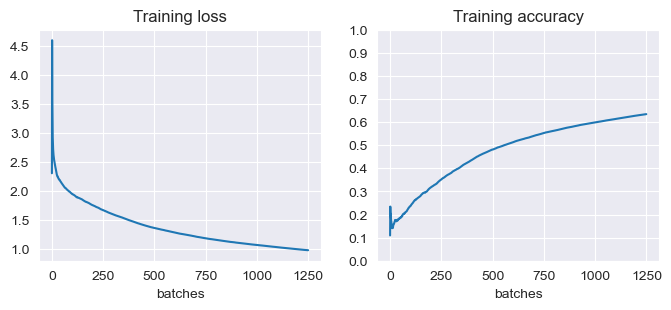

In [20]:
'''#DONE: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
#ADDED: Re-run this to "re-start" training
my_model = MyCNNModel(conv_spec, fc_spec, n_classes).to(device)

my_trainer = Trainer(my_model, cfg)
train_loss, train_acc = my_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3)) #ADDED: figsize
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy');

#ADDED for axes and printing
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax0.set_xlabel('batches')
ax1.set_xlabel('batches')
print(f'Final running batch averages are {train_loss[-1]:.2f} loss and {train_acc[-1]:.1%} acurracy')

Final running batch averages are 0.66 loss and 79.6% acurracy


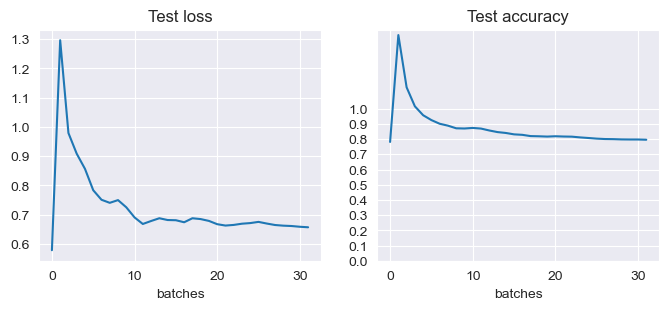

In [21]:
'''#DONE: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = my_trainer.test(test_data)
test_acc = [t.cpu() for t in test_acc] #ADDED: move test_acc tensor from MPS to CPU
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3)) #ADDED: figsize
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

#ADDED for axes and printing
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax0.set_xlabel('batches')
ax1.set_xlabel('batches')
print(f'Final running batch averages are {test_loss[-1]:.2f} loss and {test_acc[-1]:.1%} acurracy')

## Task 3: Tune your training hyperparameters (optional, 10 pt)

Implement a method <code>grid_search</code>, which looks for the best possible learning rates and training batch sizes for your model <code>MyCNNModel</code> and returns the best possible model, the corresponding training configuration, and the final training avg losses and accuracies (as numbers).

In [22]:
#ADDED library
import copy

def grid_search(train_dataset, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7]):
    '''#DONE: here your code '''

    #Loop through all combinations of two hyperparameters
    i = 0
    best_avg_acc = -0.1 #Always initializes best model with first model, even if train_acc is 0!
    for bs in batch_sizes:
        for lr in learning_rates:
            #Setup this iteration's config
            i += 1
            cfg_i = cfg
            cfg_i['batch_size'] = bs
            cfg_i['learning_rate'] = lr

            #Instantiate model and trainer, run training
            print(f'Training model with batch size {bs} and learning rate {lr}')
            model_i = MyCNNModel(conv_spec, fc_spec, n_classes).to(device) #arguments defined outside of function
            trainer_i = Trainer(model_i, cfg_i)
            train_loss_i, train_acc_i = trainer_i.train(train_data)

            #Keep best model/config/loss/acc
            if i==0 or train_acc_i[-1] > best_avg_acc:
                best_model = copy.deepcopy(model_i) #probably need this too!
                best_cfg = cfg_i.copy() #need this copy()!
                best_avg_loss = train_loss_i[-1]
                best_avg_acc = train_acc_i[-1]

    return best_model, best_cfg, best_avg_loss, best_avg_acc

best_model, best_cfg, best_avg_loss, best_avg_acc = grid_search(train_data, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7])
print(f'Best model has batch size {best_cfg['batch_size']} and learning rate {best_cfg['learning_rate']}') #ADDED
print(f"Best model achieves {best_avg_loss:.2f} loss and {best_avg_acc:.1%} accuracy")

Training model with batch size 32 and learning rate 0.1


Epoch:0 - Avg loss:44469736.84268 - Avg acc:0.10003: 100%|██████████| 250/250 [00:47<00:00,  5.29it/s] 
Epoch:1 - Avg loss:22190310.72341 - Avg acc:0.10001: 100%|██████████| 250/250 [00:46<00:00,  5.36it/s]
Epoch:2 - Avg loss:14783665.72573 - Avg acc:0.09963: 100%|██████████| 250/250 [00:46<00:00,  5.34it/s]
Epoch:3 - Avg loss:11084050.25698 - Avg acc:0.09960: 100%|██████████| 250/250 [00:46<00:00,  5.33it/s]
Epoch:4 - Avg loss:8865465.80038 - Avg acc:0.09853: 100%|██████████| 250/250 [00:46<00:00,  5.34it/s] 
Epoch:5 - Avg loss:7386902.84413 - Avg acc:0.09859: 100%|██████████| 250/250 [00:46<00:00,  5.33it/s]
Epoch:6 - Avg loss:6331027.98264 - Avg acc:0.09838: 100%|██████████| 250/250 [00:47<00:00,  5.32it/s]
Epoch:7 - Avg loss:5539253.88708 - Avg acc:0.09791: 100%|██████████| 250/250 [00:46<00:00,  5.33it/s]
Epoch:8 - Avg loss:4923507.82538 - Avg acc:0.09720: 100%|██████████| 250/250 [00:47<00:00,  5.29it/s]
Epoch:9 - Avg loss:4430960.25515 - Avg acc:0.09775: 100%|██████████| 250/250

Training model with batch size 32 and learning rate 0.01


Epoch:9 - Avg loss:3.11702 - Avg acc:0.09588: 100%|██████████| 250/250 [00:51<00:00,  4.87it/s]


Training model with batch size 32 and learning rate 0.001


Epoch:9 - Avg loss:0.87495 - Avg acc:0.67487: 100%|██████████| 250/250 [00:47<00:00,  5.31it/s]


Training model with batch size 64 and learning rate 0.1


Epoch:0 - Avg loss:47257400.01102 - Avg acc:0.10282: 100%|██████████| 125/125 [00:43<00:00,  2.89it/s]
Epoch:1 - Avg loss:23533806.78591 - Avg acc:0.09852: 100%|██████████| 125/125 [00:47<00:00,  2.63it/s]
Epoch:2 - Avg loss:15668230.42290 - Avg acc:0.09956: 100%|██████████| 125/125 [00:46<00:00,  2.67it/s]
Epoch:3 - Avg loss:11743323.58033 - Avg acc:0.09879: 100%|██████████| 125/125 [00:47<00:00,  2.65it/s]
Epoch:4 - Avg loss:9390895.44084 - Avg acc:0.09906: 100%|██████████| 125/125 [00:44<00:00,  2.81it/s]
Epoch:5 - Avg loss:7823656.93455 - Avg acc:0.09901: 100%|██████████| 125/125 [00:45<00:00,  2.77it/s]
Epoch:6 - Avg loss:6704713.19508 - Avg acc:0.09893: 100%|██████████| 125/125 [00:44<00:00,  2.84it/s]
Epoch:7 - Avg loss:5865785.40662 - Avg acc:0.09897: 100%|██████████| 125/125 [00:44<00:00,  2.82it/s]
Epoch:8 - Avg loss:5213451.87726 - Avg acc:0.09814: 100%|██████████| 125/125 [00:44<00:00,  2.81it/s]
Epoch:9 - Avg loss:4691689.51070 - Avg acc:0.09802: 100%|██████████| 125/125 [

Training model with batch size 64 and learning rate 0.01


Epoch:9 - Avg loss:3.72487 - Avg acc:0.09578: 100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Training model with batch size 64 and learning rate 0.001


Epoch:9 - Avg loss:0.94553 - Avg acc:0.64973: 100%|██████████| 125/125 [00:41<00:00,  3.01it/s]


Training model with batch size 128 and learning rate 0.1


Epoch:0 - Avg loss:83576792.29236 - Avg acc:0.09980: 100%|██████████| 63/63 [00:38<00:00,  1.65it/s] 
Epoch:1 - Avg loss:41454091.68118 - Avg acc:0.09881: 100%|██████████| 63/63 [00:38<00:00,  1.65it/s]
Epoch:2 - Avg loss:27562561.73200 - Avg acc:0.09811: 100%|██████████| 63/63 [00:38<00:00,  1.65it/s]
Epoch:3 - Avg loss:20644469.12752 - Avg acc:0.09892: 100%|██████████| 63/63 [00:38<00:00,  1.64it/s]
Epoch:4 - Avg loss:16502426.42156 - Avg acc:0.09987: 100%|██████████| 63/63 [00:38<00:00,  1.64it/s]
Epoch:5 - Avg loss:13744726.90165 - Avg acc:0.09964: 100%|██████████| 63/63 [00:38<00:00,  1.64it/s]
Epoch:6 - Avg loss:11776732.24415 - Avg acc:0.10051: 100%|██████████| 63/63 [00:38<00:00,  1.64it/s]
Epoch:7 - Avg loss:10301714.37934 - Avg acc:0.10034: 100%|██████████| 63/63 [00:38<00:00,  1.62it/s]
Epoch:8 - Avg loss:9155057.38222 - Avg acc:0.10020: 100%|██████████| 63/63 [00:39<00:00,  1.61it/s] 
Epoch:9 - Avg loss:8238096.38153 - Avg acc:0.10033: 100%|██████████| 63/63 [00:38<00:00,  

Training model with batch size 128 and learning rate 0.01


Epoch:9 - Avg loss:5.20162 - Avg acc:0.09807: 100%|██████████| 63/63 [00:38<00:00,  1.64it/s]


Training model with batch size 128 and learning rate 0.001


Epoch:9 - Avg loss:1.00465 - Avg acc:0.62386: 100%|██████████| 63/63 [00:38<00:00,  1.62it/s]

Best model has batch size 32 and learning rate 0.001
Best model achieves 0.87 loss and 67.5% accuracy


Final running batch averages are 0.60 loss and 80.6% acurracy


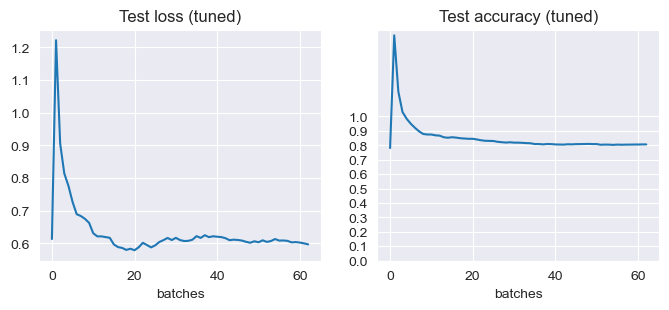

In [23]:
#ADDED: instantiate new trainer with best model, use for checking test loss/accuracy only
my_best_trainer = Trainer(best_model, best_cfg)
best_test_loss, best_test_acc = my_best_trainer.test(test_data)
best_test_acc = [t.cpu() for t in best_test_acc] #Move test_acc tensor from MPS to CPU
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
ax0.plot(range(len(best_test_loss)), best_test_loss)
ax1.plot(range(len(best_test_acc)), best_test_acc)
ax0.set_title('Test loss (tuned)')
ax1.set_title('Test accuracy (tuned)')
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax0.set_xlabel('batches')
ax1.set_xlabel('batches')
print(f'Final running batch averages are {best_test_loss[-1]:.2f} loss and {best_test_acc[-1]:.1%} acurracy')

In [24]:
#ADDED: Build DataFrame for reporting later in Task 5
import pandas as pd
df_t23 = pd.DataFrame(np.nan,
                  index = ['Accuracy (train)', 'Loss (train)', 'Accuracy (test)', 'Loss (test)'],
                  columns = ['your model', 'your tuned model'])
df_t23.index.name = 'Test metric'

#Input base model metrics
df_t23['your model'] = [train_acc[-1], train_loss[-1], test_acc[-1].item(), test_loss[-1]]
df_t23['your tuned model'] = [best_avg_acc, best_avg_loss, best_test_acc[-1].item(), best_test_loss[-1]]
df_t23

,your model,your tuned model
Test metric,,
Accuracy (train),0.634545,0.674870
Loss (train),0.976045,0.874952
Accuracy (test),0.795867,0.806452
Loss (test),0.657359,0.597188


## Task 4: Load and fine-tune a pre-trained model (10 pt)

<ul>
  <li>Load and train a pre-trained model for classification problems, such as those made available in <a href="https://huggingface.co/docs/timm">Hugging Face's timm library</a>. </li>
  <li> Make sure to modify the output layer to be compatible with the number of classes. </li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>
  
<b>Note</b>: in case you run into computing-related (e.g. memory) issues, consider choosing another model.

### 📝 Pre-Trained Model Choice
We chose **ResNet-18** for our pre-trained model because the ResNet family of CNNs has proven to be highly effective at image classification tasks by taking advantage of its innovations of using residual/skip connections and batch normalization layers which were not permitted for our own custom architecture in Task 2. Thus, it would make a good comparison point. The EuroSAT paper (Helber et al., 2015) lists the ResNet-50 as among the best-performing models so we hope that choosing its shallower (less layers) version would approach that effectiveness on the exact same task.

In [25]:
'''#DONE: import and fine-tune a pretrained model'''
#ADDED libraries
from torchvision import models
from torchvision.models.resnet import resnet18, ResNet18_Weights

pre_train_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze early layers to retain pre-trained feature extraction
for param in pre_train_model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match EuroSAT's 10 classes
num_features = pre_train_model.fc.in_features
pre_train_model.fc = nn.Linear(num_features, len(data.classes))

pre_train_trainer = Trainer(pre_train_model, cfg)


Epoch:9 - Avg loss:0.60245 - Avg acc:0.81556: 100%|██████████| 63/63 [00:33<00:00,  1.89it/s]

Final running batch averages are 0.60 loss and 81.6% acurracy


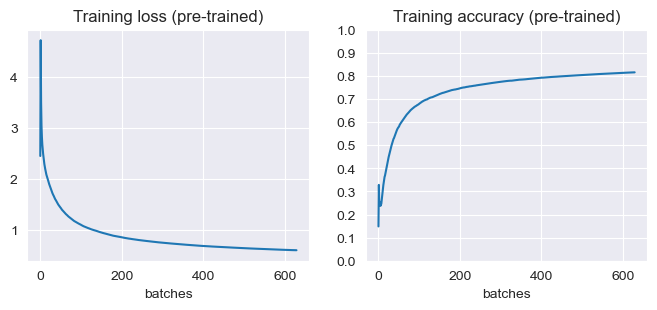

In [26]:
'''#DONE: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
pretrain_loss, pretrain_acc = pre_train_trainer.train(train_data) #EDITED: variable names to not overwrite above
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
ax0.plot(range(len(pretrain_loss)), pretrain_loss)
ax1.plot(range(len(pretrain_acc)), pretrain_acc)
ax0.set_title('Training loss (pre-trained)')
ax1.set_title('Training accuracy (pre-trained)')

#ADDED for axes and printing
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax0.set_xlabel('batches')
ax1.set_xlabel('batches')
print(f'Final running batch averages are {pretrain_loss[-1]:.2f} loss and {pretrain_acc[-1]:.1%} acurracy')

Final running batch averages are 0.52 loss and 89.5% acurracy


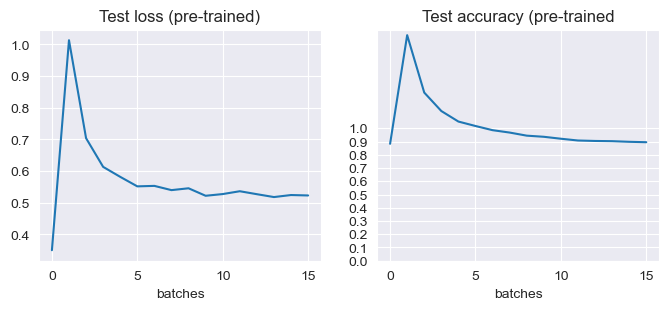

In [27]:
'''#DONE: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
pretrain_test_loss, pretrain_test_acc = pre_train_trainer.test(test_data) #EDITED: variable names to not overwrite above
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
ax0.plot(range(len(pretrain_test_loss)), pretrain_test_loss)
ax1.plot(range(len(pretrain_test_acc)), pretrain_test_acc)
ax0.set_title('Test loss (pre-trained)')
ax1.set_title('Test accuracy (pre-trained')

#ADDED for axes and printing
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax0.set_xlabel('batches')
ax1.set_xlabel('batches')
print(f'Final running batch averages are {pretrain_test_loss[-1]:.2f} loss and {pretrain_test_acc[-1]:.1%} acurracy')

In [34]:
# Load pretrained model again for tuned model
tuned_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Unfreeze last two layers (layer4 and fc)
for name, param in tuned_model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Replace final layer
num_features = tuned_model.fc.in_features
tuned_model.fc = nn.Linear(num_features, len(data.classes))
tuned_model = tuned_model.to(device)

# Train again using the same Trainer
tuned_trainer = Trainer(tuned_model, cfg)
tuned_train_loss, tuned_train_acc = tuned_trainer.train(train_data)

Epoch:9 - Avg loss:0.14270 - Avg acc:0.95331: 100%|██████████| 63/63 [00:09<00:00,  6.44it/s]


Final running batch averages are 0.24 loss and 99.6% acurracy


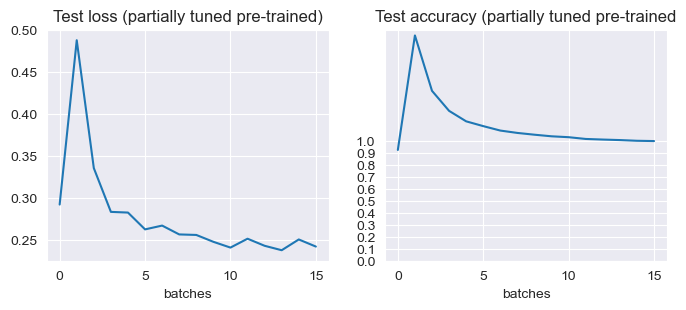

In [36]:
tuned_test_loss, tuned_test_acc = tuned_trainer.test(test_data)
tuned_test_acc = [t.cpu() for t in tuned_test_acc] #Move test_acc tensor from MPS to CPU
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
ax0.plot(range(len(tuned_test_loss)), tuned_test_loss)
ax1.plot(range(len(tuned_test_acc)), tuned_test_acc)
ax0.set_title('Test loss (partially tuned pre-trained)')
ax1.set_title('Test accuracy (partially tuned pre-trained')

#ADDED for axes and printing
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax0.set_xlabel('batches');
ax1.set_xlabel('batches');
print(f'Final running batch averages are {tuned_test_loss[-1]:.2f} loss and {tuned_test_acc[-1]:.1%} acurracy')

In [37]:
#Fully fine tuned model (with all layers being unfrozen)
full_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Replace final FC layer
num_features = full_model.fc.in_features
full_model.fc = nn.Linear(num_features, len(data.classes))
full_model = full_model.to(device)

# Unfreeze all layers
for param in full_model.parameters():
    param.requires_grad = True

# # Train again using the same Trainer
full_trainer = Trainer(full_model, cfg)
full_train_loss, full_train_acc = full_trainer.train(train_data)



Epoch:9 - Avg loss:0.19153 - Avg acc:0.93988: 100%|██████████| 63/63 [00:15<00:00,  4.20it/s]


Final running batch averages are 0.34 loss and 96.6% acurracy


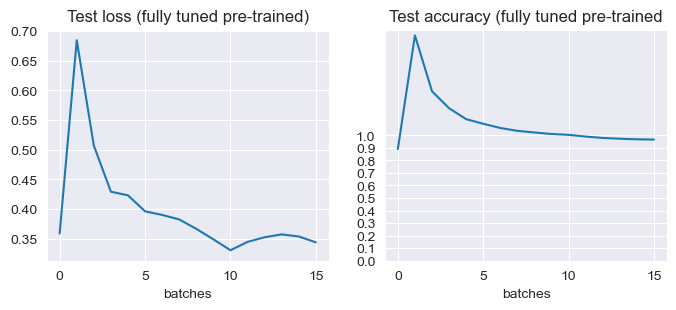

In [38]:
full_tuned_test_loss, full_tuned_test_acc = full_trainer.test(test_data)
full_tuned_test_acc = [t.cpu() for t in full_tuned_test_acc] #Move test_acc tensor from MPS to CPU
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
ax0.plot(range(len(full_tuned_test_loss)), full_tuned_test_loss)
ax1.plot(range(len(full_tuned_test_acc)), full_tuned_test_acc)
ax0.set_title('Test loss (fully tuned pre-trained)')
ax1.set_title('Test accuracy (fully tuned pre-trained')

#ADDED for axes and printing
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax0.set_xlabel('batches');
ax1.set_xlabel('batches');
print(f'Final running batch averages are {full_tuned_test_loss[-1]:.2f} loss and {full_tuned_test_acc[-1]:.1%} acurracy')

### 📝 Summary of Results

In [39]:
#Build DataFrame for reporting
df_t4 = pd.DataFrame(np.nan,
                  index = ['Accuracy (train)', 'Loss (train)', 'Accuracy (test)', 'Loss (test)'],
                  columns = ['pre-trained model', 'fine-tuned model (partial)','fine-tuned model (full)' ])
df_t4.index.name = 'Test metric'

#Input pre-trained/fine-tuned metrics
df_t4['pre-trained model'] = [pretrain_acc[-1], pretrain_loss[-1], pretrain_test_acc[-1].item(), pretrain_test_loss[-1]]
df_t4['fine-tuned model (partial)'] = [tuned_train_acc[-1], tuned_train_loss[-1], tuned_test_acc[-1].item(), tuned_test_loss[-1]]
df_t4['fine-tuned model (full)'] = [full_train_acc[-1], full_train_loss[-1], full_tuned_test_acc[-1].item(), full_tuned_test_loss[-1]]
df_t4

,pre-trained model,fine-tuned model (partial),fine-tuned model (full)
Test metric,,,
Accuracy (train),0.815555,0.953311,0.939885
Loss (train),0.602449,0.142698,0.191528
Accuracy (test),0.894688,0.995937,0.966146
Loss (test),0.522895,0.241826,0.344096


<a name="results-and-discussion"></a>
## Task  5: Results and discussion (5pt)

Report the final metrics and make a few comments on the overall performance for the networks you implemented (3-4 lines).

| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)           |              |             |                |                     
| Loss (train)               |               |             |                |    
| Accuracy (test)           |              |             |                |                     
| Loss (test)               |               |             |                |              
             





In [40]:
#ADDED: combine reporting DataFrames
pd.concat([df_t23, df_t4], axis=1)

,your model,your tuned model,pre-trained model,fine-tuned model (partial),fine-tuned model (full)
Test metric,,,,,
Accuracy (train),0.634545,0.674870,0.815555,0.953311,0.939885
Loss (train),0.976045,0.874952,0.602449,0.142698,0.191528
Accuracy (test),0.795867,0.806452,0.894688,0.995937,0.966146
Loss (test),0.657359,0.597188,0.522895,0.241826,0.344096


### 📝 Discussion on Overall Performance
The final metrics are consistent with our expectations. Our custom CNN with significantly shallower layers than modern CNNs gave a modest test accuracy of 80% but improved to 81% after tuning the batch size and learning rate. The deeper ResNet-18 pre-trained model with features (residual/skip, batch norm) to enable deeper layers to stably learn indeed shows better performance with 89% test accuracy as-is (only output layer customized) and  improves significantly to 99.6% after fine-tuning on our dataset by unfreezing the last FC layer. When running another fine tuned model with unfreezing all layers, the test accuracy went down to 97%. This is possibly due to it overwriting pre-trained features from the already good ResNet 18 model that generalized well. Loss scores also trend (in opposite direction) accordingly.

## References
1. Helber, P., Bischke, B., Dengel, A., & Borth, D. (2017). *EuroSAT: A novel dataset and deep learning benchmark for land use and land cover classification.* IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing. https://doi.org/10.1109/JSTARS.2019.2918242
2. Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2024). *Dive into deep learning* (Release 1.2.0). Retrieved from https://d2l.ai
3. "How small should the HxW output of the last convolution block be?" prompt. *ChatGPT-5*, OpenAI, 2025, October 13, https://chatgpt.com
4. "Is a jump from 3 to 64 channels immediately ok?" prompt. *ChatGPT-5*, OpenAI, 2025, October 13, https://chatgpt.com
5. "If I write a custom module in place of nn.MaxPool2d would it be too slow to run in a CNN?” prompt. *ChatGPT-5*, OpenAI, 2025, October 15, https://chatgpt.com
6. "Custom functon for maxpool please?” prompt. *ChatGPT-5*, OpenAI, 2025, October 15, https://chatgpt.com